# Dimensionality reduction algorithms comparison

This notebook produces plots fort he following dimensionality reduction algorithm techniques:

- UMAP [preferred]
- tSNE [precursor to UMAP]
- PCA [DON'T USE THIS FOR deep learning, it's linear ONLY!]

The data is `tweets-all-new-20220117` → GloVe.

In [32]:
import os

import tensorflow as tf
import umap
import umap.plot
from tsnecuda import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datashader as ds
import colorcet
from nltk.corpus import stopwords

# from dask.distributed import Client

from lib.glove.glove import GloVe

In [2]:
filepath_words = "/mnt/research-data/main/twitter/new/UMAP-tweets-all-new-20220117-wordlist.txt"
# Multilingual, ref https://github.com/stopwords-iso/stopwords-iso/blob/682bcc330e7ebca13e928349263560e3bae84830/stopwords-iso.json
filepath_stopwords = "/mnt/research-data/main/stopwords.txt"


In [3]:
with open(filepath_stopwords) as handle:
	stopwords = [ word.strip() for word in handle ]

In [4]:
words = []
with open(filepath_words) as handle:
	stopwords_skipped = 0
	for line in handle:
		row = line.split("\t", maxsplit=1)
		if row == "" or len(row) < 2:
			continue
		try:
			row[0] = int(row[0])
		except:
			continue
		row[1] = row[1].rstrip("\n")
		if row[1] in stopwords:
			continue
		words.append(row)


print(f"{len(words)} read, {stopwords_skipped} stopwords skipped")
	

1499544 read, 0 stopwords skipped


In [38]:
print(f"{len(words)} words loaded")
pd.DataFrame(words)

1499544


,0,1
0,1,
1,1,
2,1,
3,1,
4,1,
...,...,...
1499539,53796,&amp;
1499540,59651,I
1499541,87656,#Floods
1499542,101960,


In [6]:
glove = GloVe("/mnt/research-data/main/glove/glove.twitter.27B.25d.txt")


words_glove = [ glove.lookup(row[1]) for row in words ]
words_glove = list(filter(lambda vector: vector is not None, words_glove))

len(words_glove)

words_glove = np.array(words_glove)


Loading GloVe from '/mnt/research-data/main/glove/glove.twitter.27B.25d.txt': 1190000... done in 9.436s.


## UMAP

In [7]:
dimreducer = umap.UMAP(
	min_dist=0.05 # default: 0.1
).fit(words_glove)

/home/bryan-smithl/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


<AxesSubplot:>

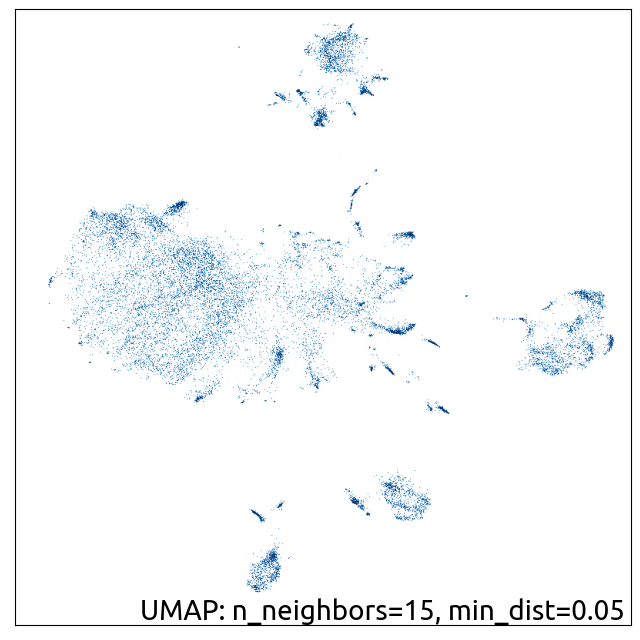

In [29]:
umap.plot.points(dimreducer,
    color_key_cmap="brg", # color_key_cmap="rainbow4",
)

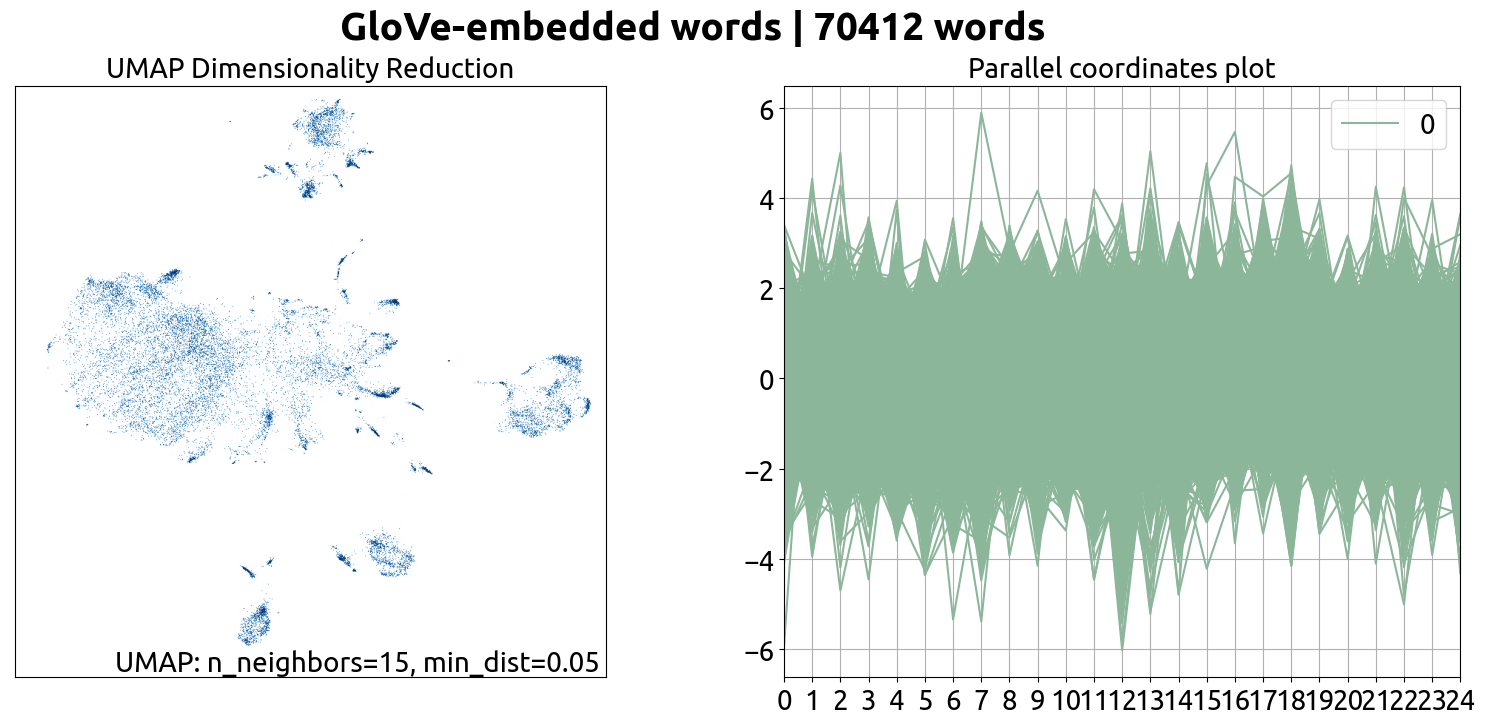

In [8]:
px = 1/plt.rcParams['figure.dpi'] # matplotlib sizes are in inches :-( :-( :-(
width = 1920
height = 768

plt.rc("font", size=20)
plt.rc("font", family="Ubuntu")
figure = plt.figure(figsize=(width*px, height*px))
figure.add_subplot(1, 2, 1)

# 1: UMAP
umap.plot.points(dimreducer,
    color_key_cmap="brg", # color_key_cmap="rainbow4",
    ax=figure.get_axes()[0]
)
plt.title(f"UMAP Dimensionality Reduction", fontsize=20)

# 2: Parallel coordinates
figure.add_subplot(1, 2, 2)

dataframe = pd.DataFrame(words_glove)
dataframe["Label"] = 0
pd.plotting.parallel_coordinates(
    dataframe,
	class_column="Label",
    ax=figure.get_axes()[1],
    use_columns=False,
    axvlines=False
)

plt.title(f"Parallel coordinates plot", fontsize=20)
plt.suptitle(f"tweets-all → GloVe → UMAP | {len(words_glove)} words", fontsize=28, weight="bold")

plt.show()

## tSNE

In [10]:
words_tsne = TSNE().fit_transform(words_glove)
# TODO: Cite this:
# @article{chan2019gpu,
# 	title={GPU accelerated t-distributed stochastic neighbor embedding},
# 	author={Chan, David M and Rao, Roshan and Huang, Forrest and Canny, John F},
# 	journal={Journal of Parallel and Distributed Computing},
# 	volume={131},
# 	pages={1--13},
# 	year={2019},
# 	publisher={Elsevier}
# }

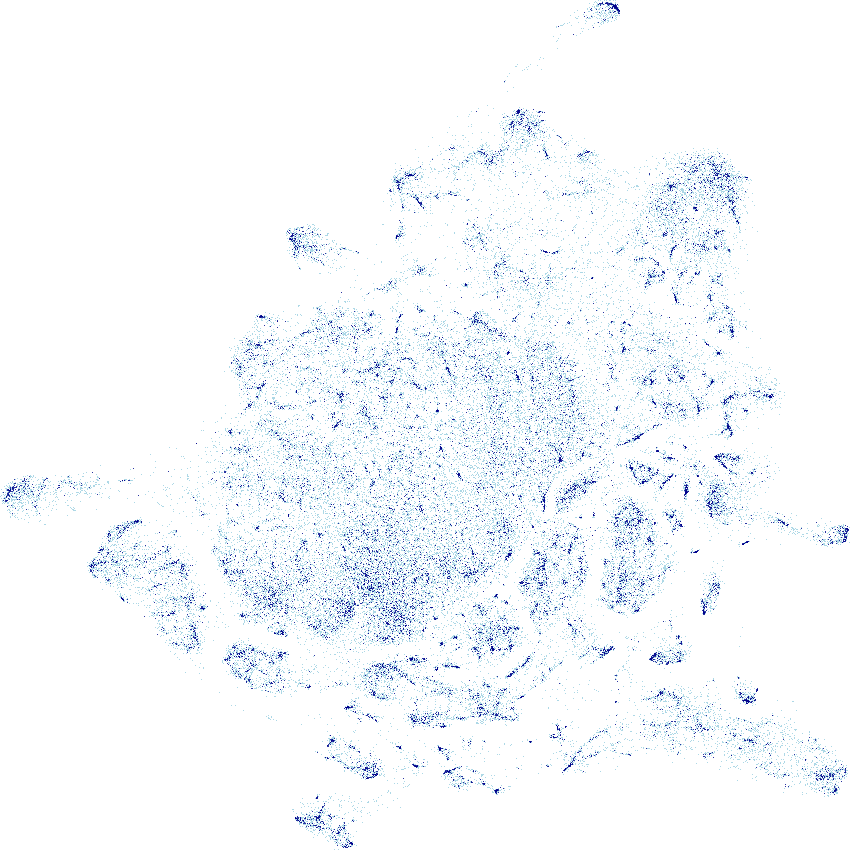

In [28]:
df_tsne = pd.DataFrame(words_tsne)
df_tsne.columns = ["x", "y"]

canvas_tsne = ds.Canvas(plot_width=850, plot_height=850)
points_tsne = canvas_tsne.points(df_tsne, "x", "y")
ds.tf.set_background(ds.tf.shade(points_tsne), color="white")

## PCA

In [34]:
pca = PCA(n_components=2)
pca.fit(words_glove)
words_pca = pca.transform(words_glove)

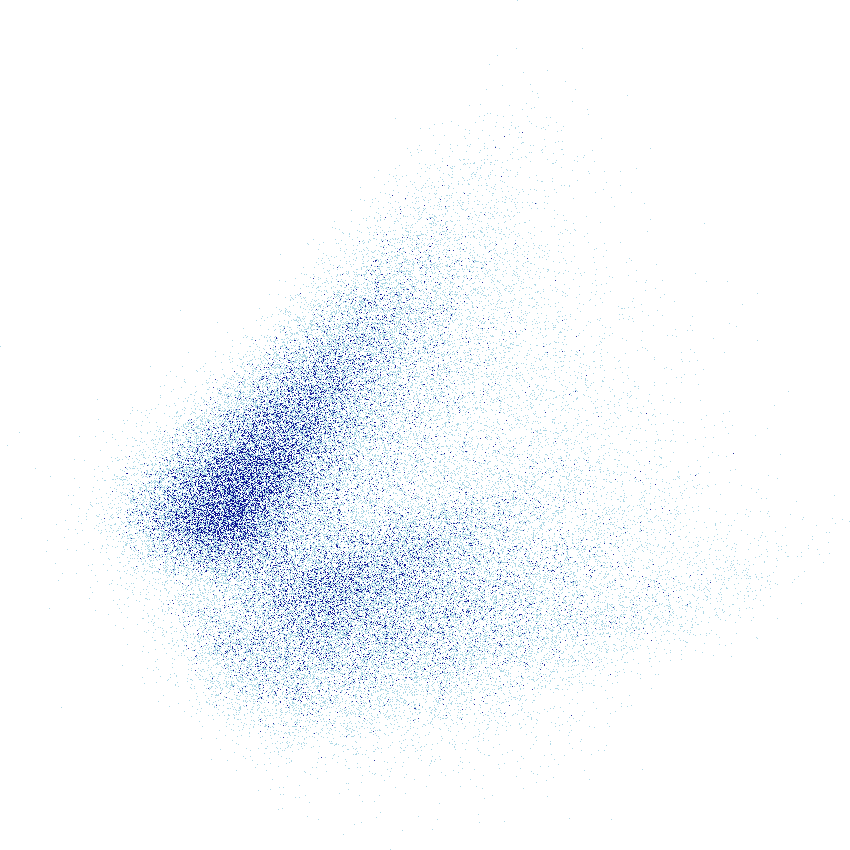

In [37]:
df_pca = pd.DataFrame(words_pca)
df_pca.columns = ["x", "y"]

canvas_pca = ds.Canvas(plot_width=850, plot_height=850)
points_pca = canvas_pca.points(df_pca, "x", "y")
ds.tf.set_background(ds.tf.shade(points_pca), color="white")
